In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path to the dataset
dataset_path = "/content/drive/MyDrive/Tumor Dataset"

# Supported image extensions
image_extensions = ('.jpg')

# Count total images
total_images = 0

# Loop through each of the 4 subfolders
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        # Count image files in the subfolder
        count = sum(
            1 for file in os.listdir(folder_path)
            if file.lower().endswith(image_extensions)
        )
        print(f"{folder_name}: {count} images")
        total_images += count

print(f"\nTotal images: {total_images}")


meningioma_tumor: 2276 images
no_tumor: 1991 images
pituitary_tumor: 2361 images
glioma_tumor: 2255 images

Total images: 8883


In [ ]:
### Imports

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob


#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


#---------------------------------------
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#---------------------------------------


import warnings
warnings.filterwarnings("ignore")


# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not founde')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_df(path):
    classes, class_paths = zip(*[(label, os.path.join(path, label, image))
                                 for label in os.listdir(path) if os.path.isdir(os.path.join(path, label))
                                 for image in os.listdir(os.path.join(path, label))])

    df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return df

In [ ]:
import pandas as pd
df = load_df('/content/drive/MyDrive/Tumor Dataset')

In [ ]:
df

,Class Path,Class
0,/content/drive/MyDrive/Tumor Dataset/meningiom...,meningioma_tumor
1,/content/drive/MyDrive/Tumor Dataset/meningiom...,meningioma_tumor
2,/content/drive/MyDrive/Tumor Dataset/meningiom...,meningioma_tumor
3,/content/drive/MyDrive/Tumor Dataset/meningiom...,meningioma_tumor
4,/content/drive/MyDrive/Tumor Dataset/meningiom...,meningioma_tumor
...,...,...
8878,/content/drive/MyDrive/Tumor Dataset/glioma_tu...,glioma_tumor
8879,/content/drive/MyDrive/Tumor Dataset/glioma_tu...,glioma_tumor
8880,/content/drive/MyDrive/Tumor Dataset/glioma_tu...,glioma_tumor
8881,/content/drive/MyDrive/Tumor Dataset/glioma_tu...,glioma_tumor


In [ ]:
### Function for counting images in each class
def count_images(df):
  plt.figure(figsize=(15,7))
  ax = sns.countplot(data=df, y=df['Class'], palette='rocket')

  plt.xlabel('')
  plt.ylabel('')
  plt.title('Count of images in each class')
  ax.bar_label(ax.containers[0])
  plt.show()

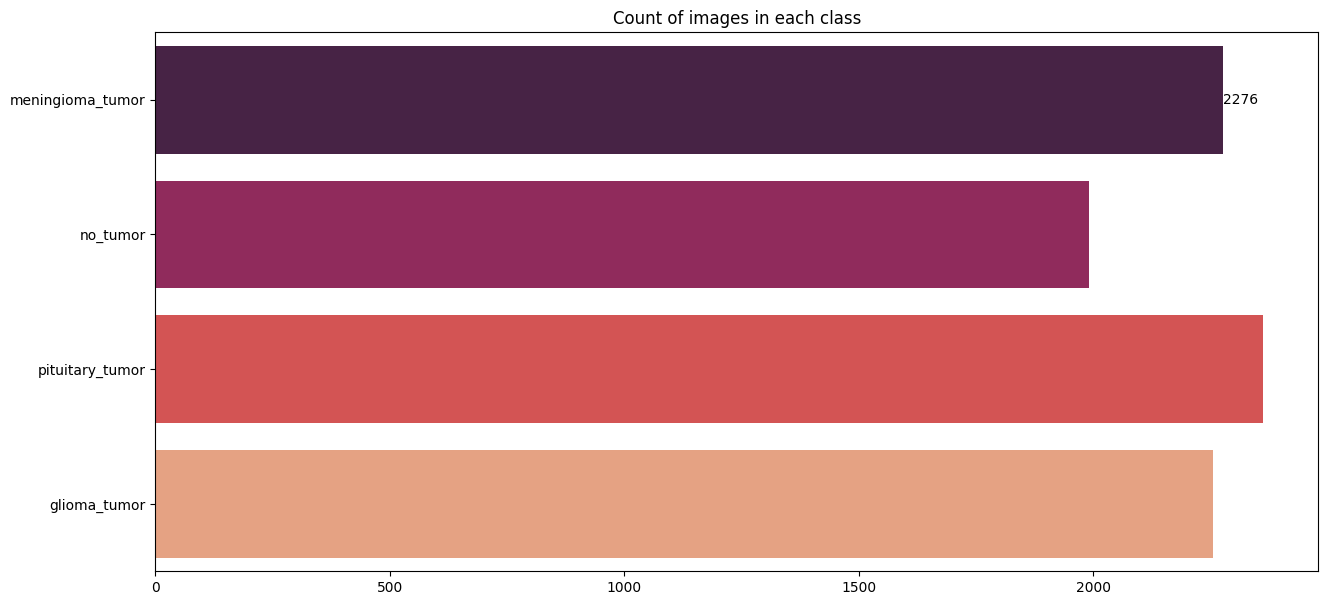

In [ ]:
count_images(df)

In [ ]:
# Train: 81.7%, Validation: 9.1%, Test: 9.2%

train_df, test_val_df = train_test_split(df, train_size=5842 / 7153, random_state=42, stratify=df['Class'])

valid_df, test_df = train_test_split(test_val_df, train_size=655 / len(test_val_df), random_state=20, stratify=test_val_df['Class'])

print(f"Train size: {len(train_df)} rows")
print(f"Validation size: {len(valid_df)} rows")
print(f"Test size: {len(test_df)} rows")

Train size: 7254 rows
Validation size: 655 rows
Test size: 974 rows


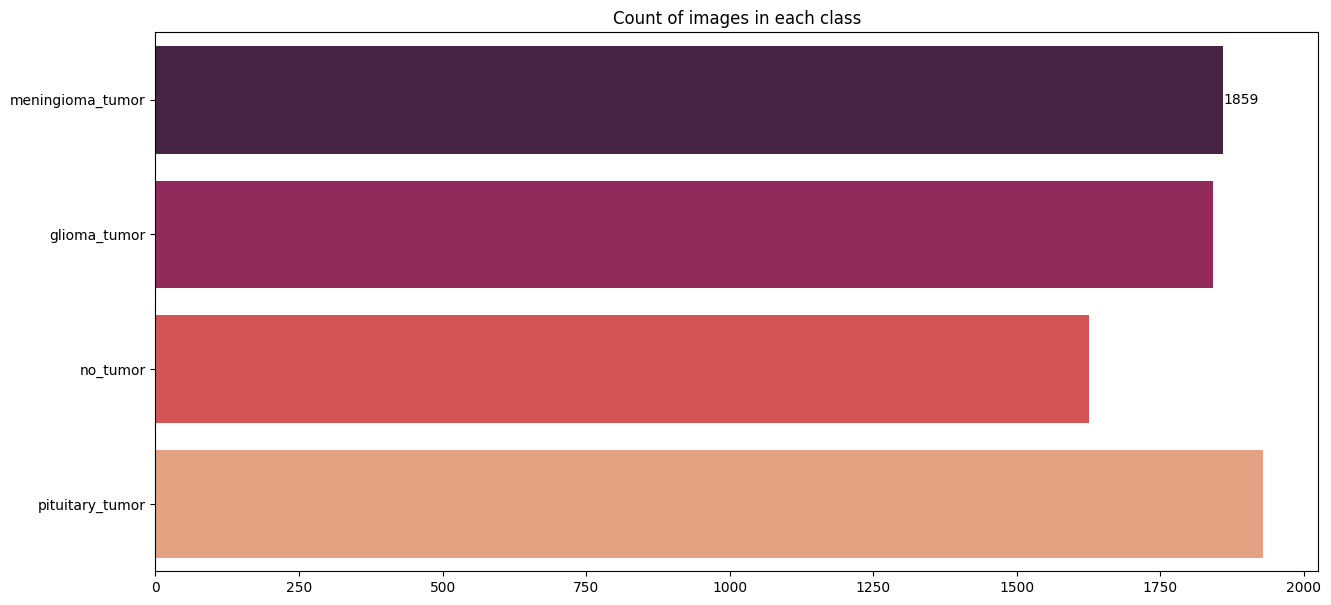

In [ ]:
count_images(train_df)

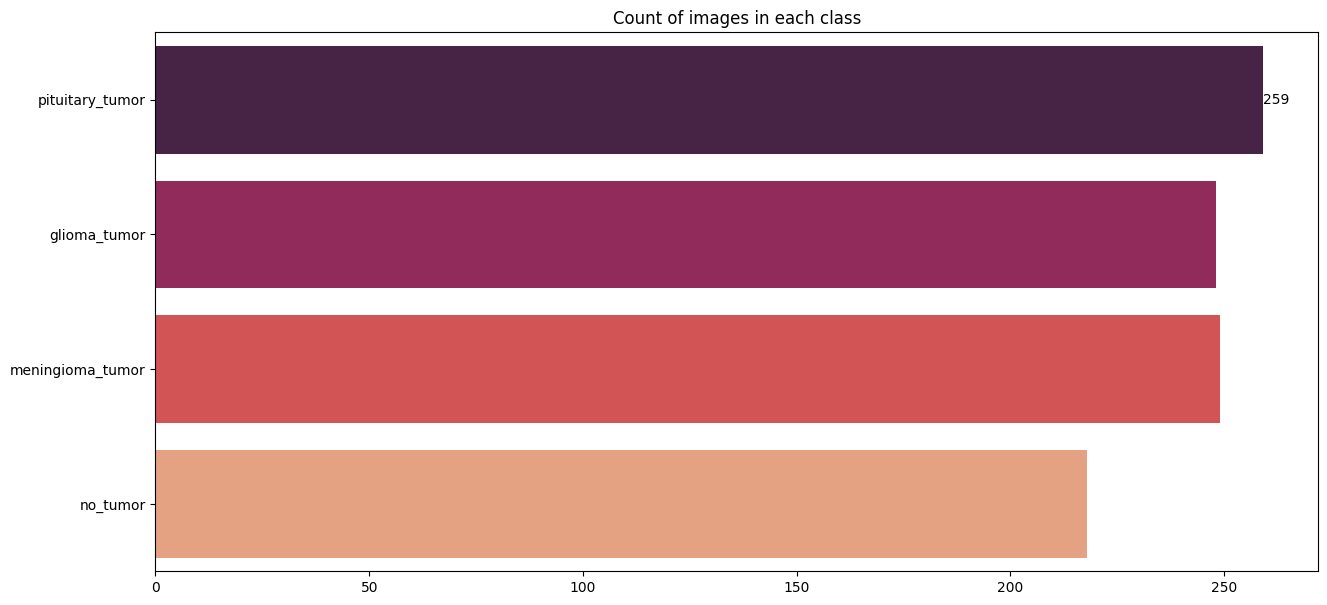

In [ ]:
count_images(test_df)

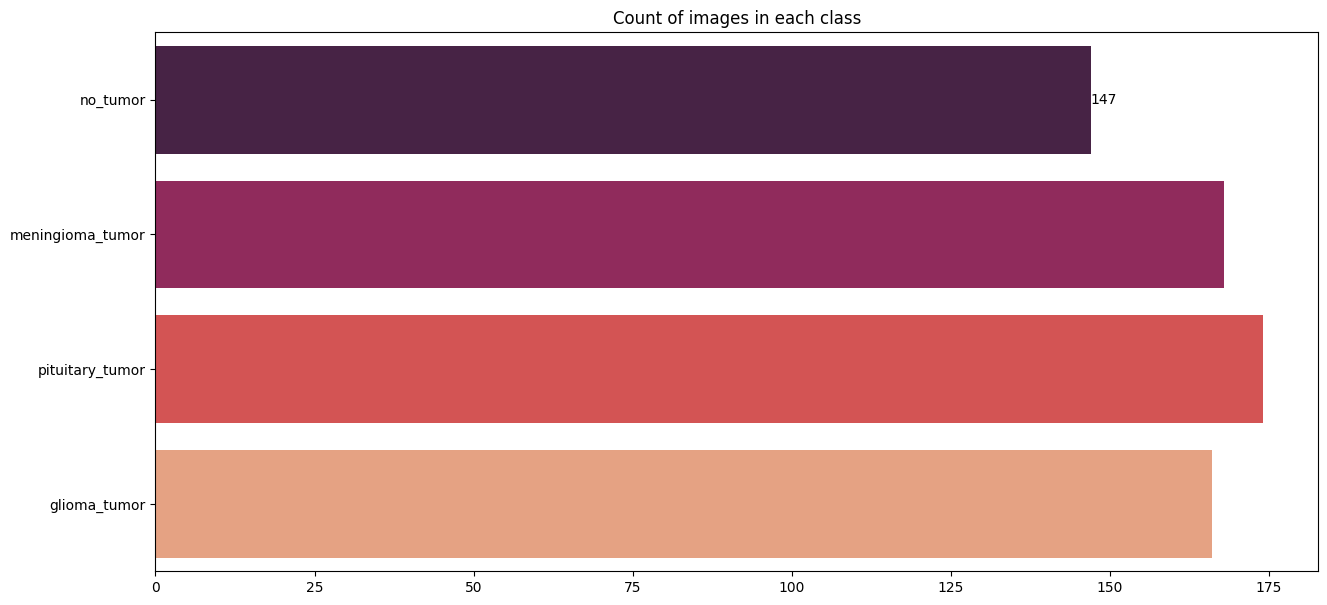

In [ ]:
count_images(valid_df)

In [ ]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 7254 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 974 validated image filenames belonging to 4 classes.


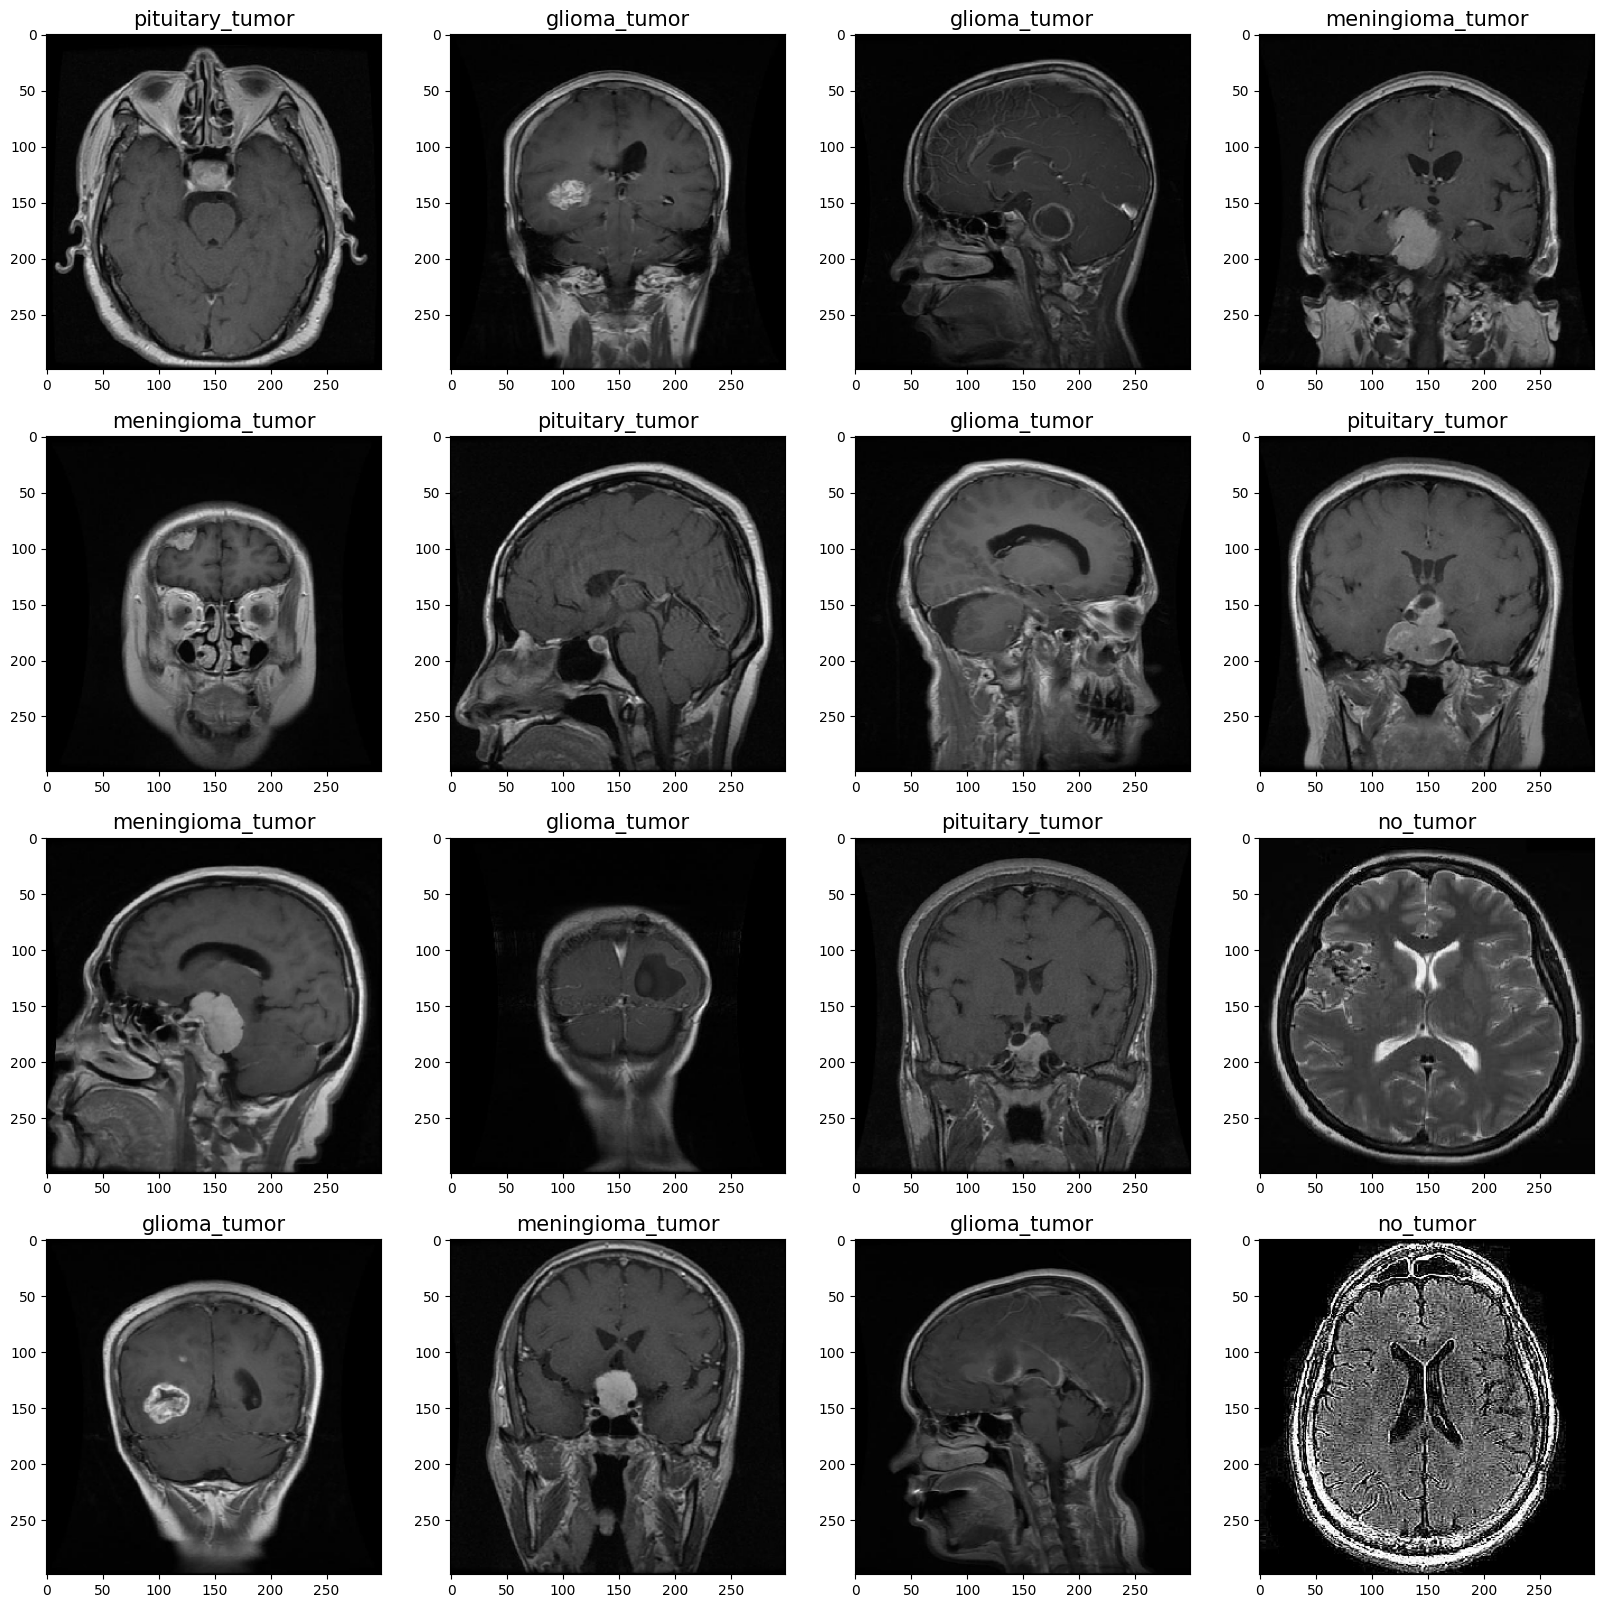

In [ ]:
class_dict = train_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(test_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [ ]:
### Model Building

img_shape = (299,299,3)
base_model = tf.keras.applications.Xception(include_top=False,
                                            weights="imagenet",
                                            input_shape=img_shape,
                                            pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
### Training Loop on GPU

with tf.device(device_name):
  hist = model.fit(train_gen,
                   epochs=10,
                   validation_data=valid_gen,
                   shuffle=False)

Epoch 1/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 4345s 19s/step - accuracy: 0.7593 - loss: 0.6729 - precision: 0.8396 - recall: 0.6560 - val_accuracy: 0.9359 - val_loss: 0.2039 - val_precision: 0.9428 - val_recall: 0.9313
Epoch 2/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 189s 831ms/step - accuracy: 0.9838 - loss: 0.0555 - precision: 0.9857 - recall: 0.9812 - val_accuracy: 0.9618 - val_loss: 0.1183 - val_precision: 0.9633 - val_recall: 0.9618
Epoch 3/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 201s 886ms/step - accuracy: 0.9910 - loss: 0.0307 - precision: 0.9916 - recall: 0.9906 - val_accuracy: 0.9878 - val_loss: 0.0441 - val_precision: 0.9878 - val_recall: 0.9863
Epoch 4/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 204s 899ms/step - accuracy: 0.9949 - loss: 0.0198 - precision: 0.9954 - recall: 0.9944 - val_accuracy: 0.9924 - val_loss: 0.0385 - val_precision: 0.9939 - val_recall: 0.9908
Epoch 5/10
227/227 ━━━━━━━━━━━━━━━━━━━━ 205s 901ms/step - accuracy: 0.9958 - loss: 0.0150 - precision: 0.9958 - recall: 0.9954 - val_accuracy: 0.

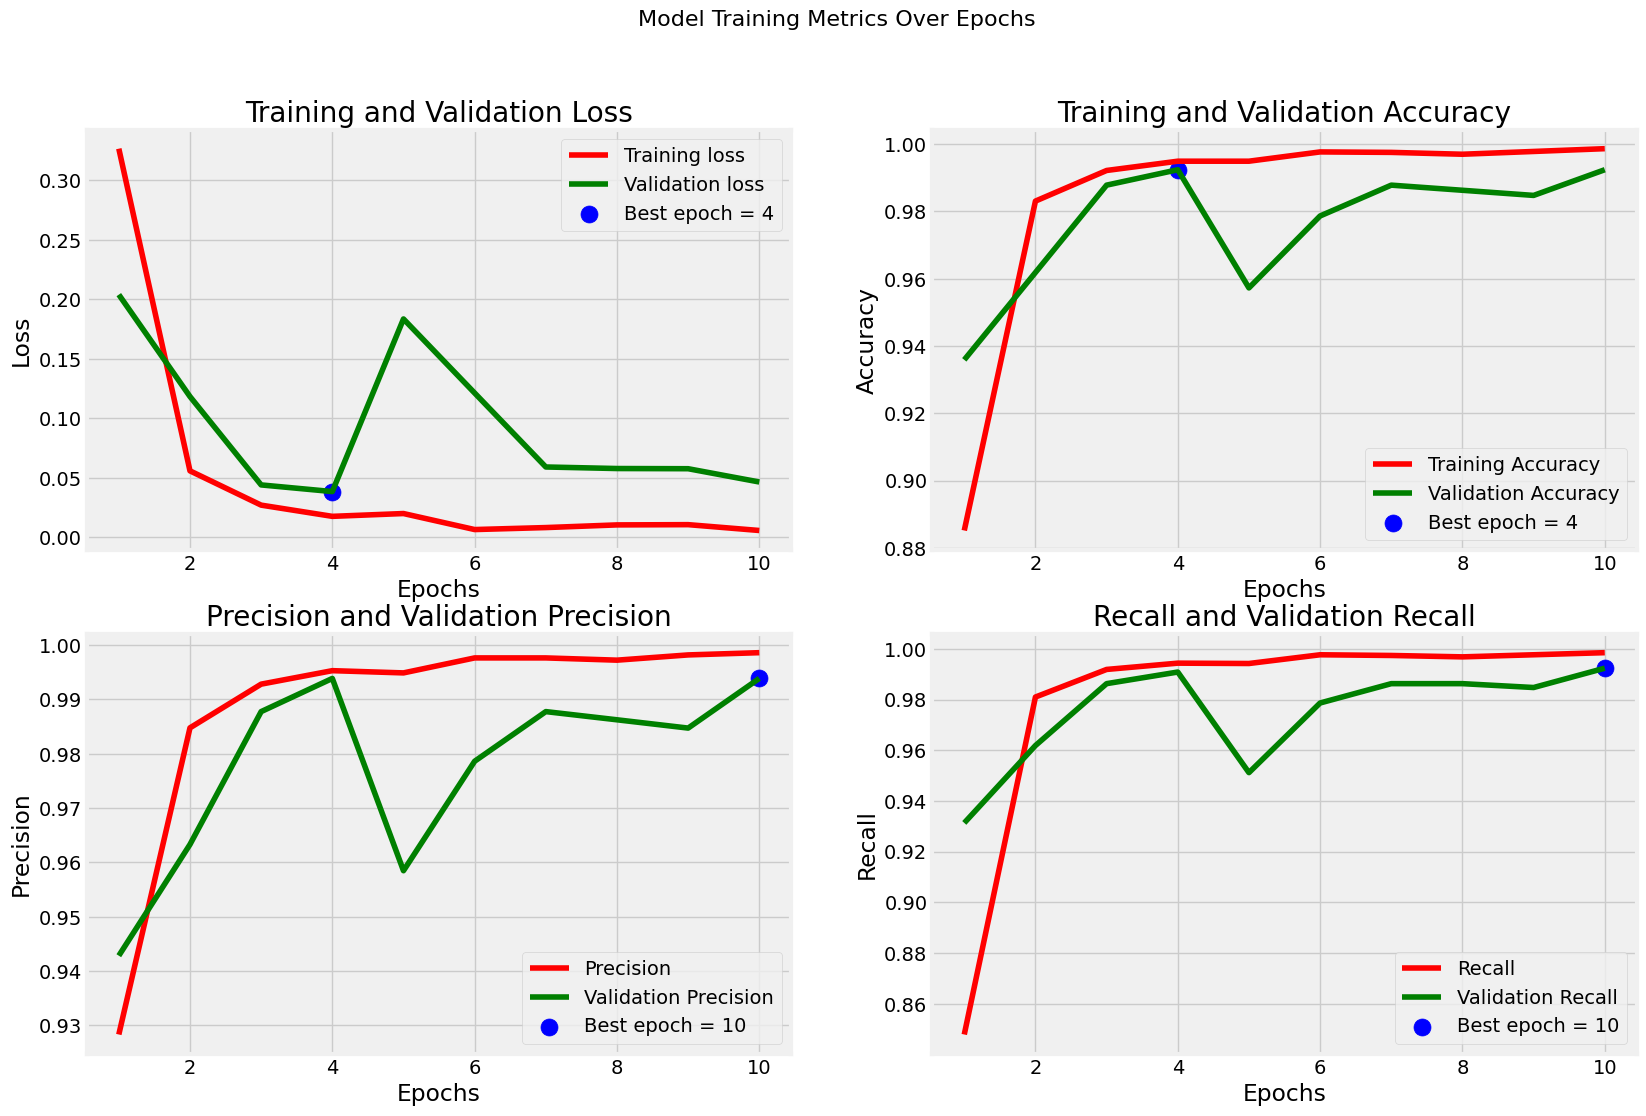

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_gen_copy = train_gen
valid_gen_copy = valid_gen
test_gen_copy = test_gen

In [ ]:
train_score = model.evaluate(train_gen_copy, verbose=1)
valid_score = model.evaluate(valid_gen_copy, verbose=1)
test_score = model.evaluate(test_gen_copy, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

227/227 ━━━━━━━━━━━━━━━━━━━━ 64s 280ms/step - accuracy: 0.9991 - loss: 0.0026 - precision: 0.9991 - recall: 0.9990
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.9932 - loss: 0.0332 - precision: 0.9948 - recall: 0.9932
61/61 ━━━━━━━━━━━━━━━━━━━━ 520s 9s/step - accuracy: 0.9868 - loss: 0.0609 - precision: 0.9878 - recall: 0.9865
Train Loss: 0.0026
Train Accuracy: 99.92%
--------------------
Validation Loss: 0.0433
Validation Accuracy: 99.24%
--------------------
Test Loss: 0.0690
Test Accuracy: 98.77%


In [ ]:
preds = model.predict(test_gen_copy)
y_pred = np.argmax(preds, axis=1)

61/61 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step


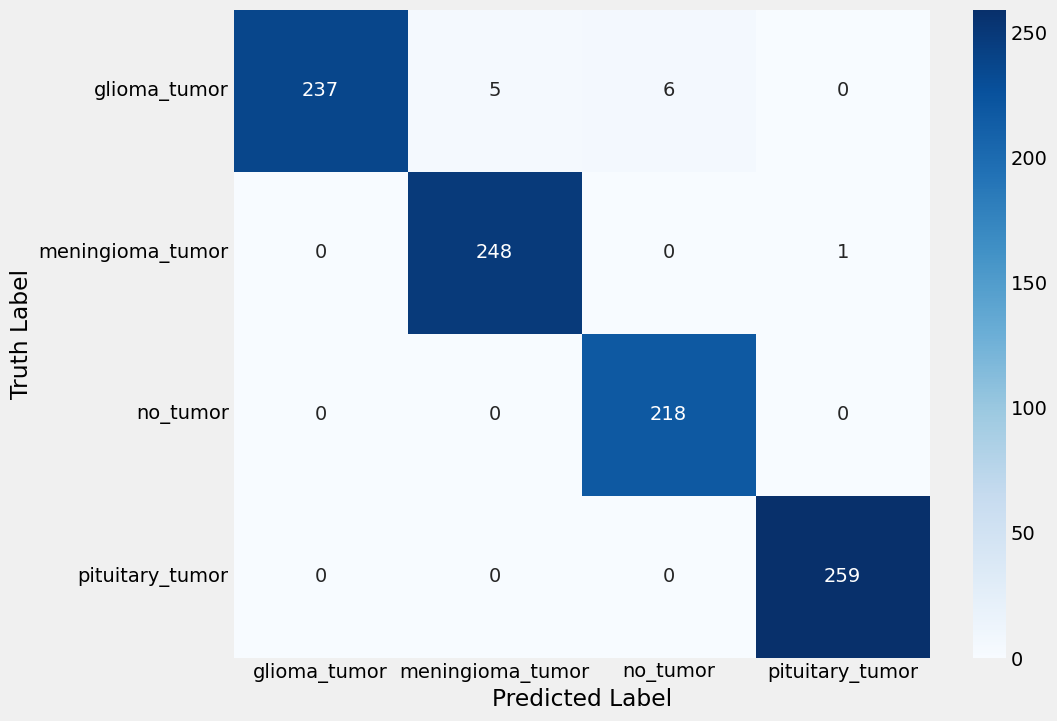

In [ ]:
### Confusion Matrix

cm = confusion_matrix(test_gen_copy.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
# Save the full model (architecture + weights + optimizer state)
model.save('/content/drive/MyDrive/Tumor Dataset')


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/Tumor Dataset.

In [ ]:
# Save the full model (architecture + weights + optimizer state)
model.save('/content/overall_brain_tumor_model_99.h5')


In [ ]:
### Functin for getting predictions

def predict(img_path):
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


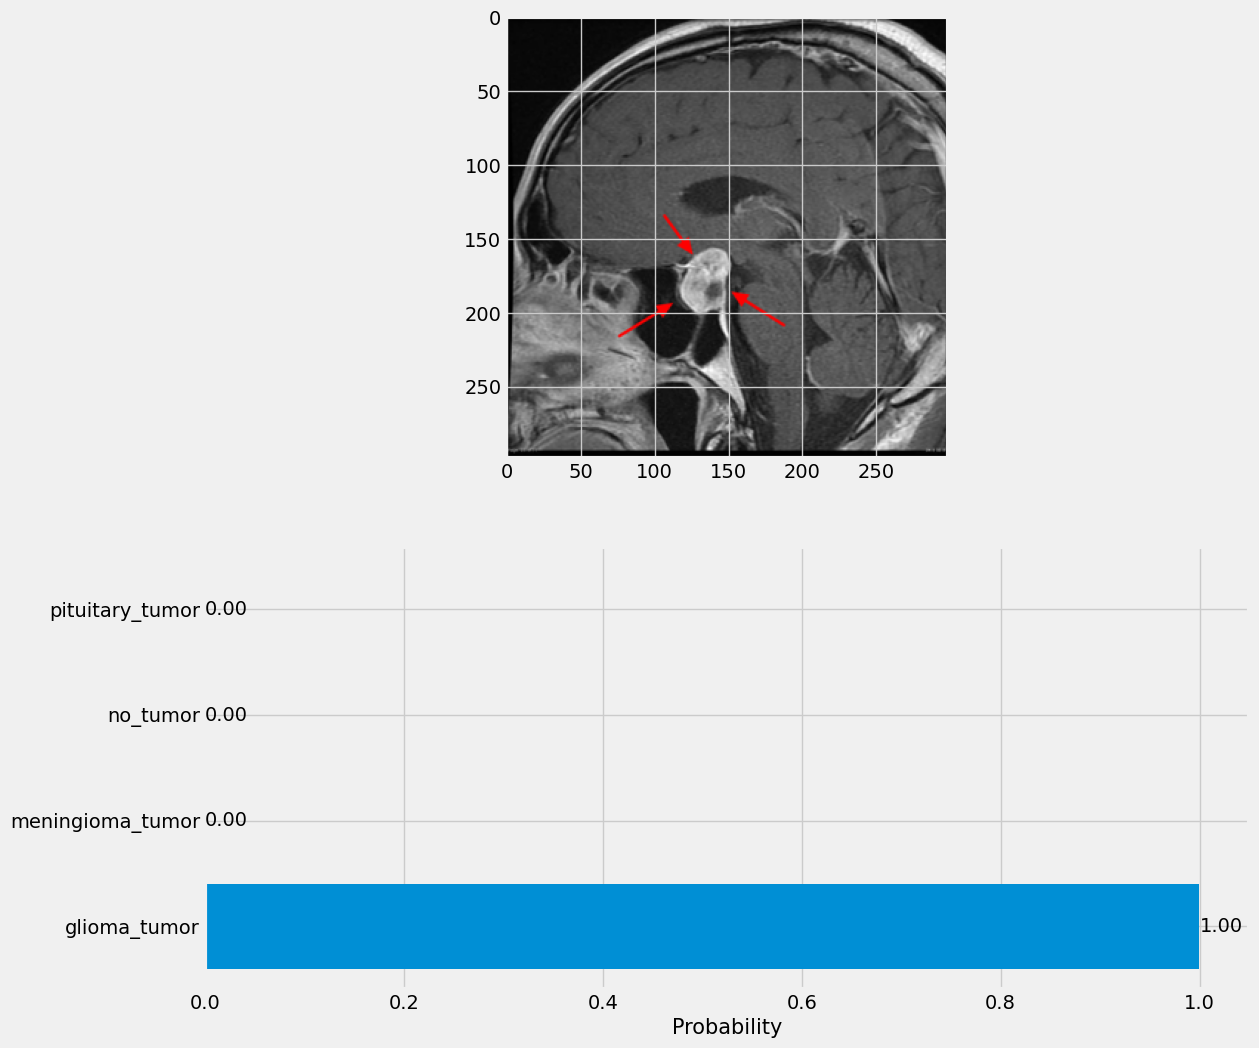

In [ ]:
from PIL import Image
img = "/content/pituitary-tumor-MRI.jpg"
predict(img)
